# T-Student regression
---
In this notebook we analyze how to adjust a *bayesian linear regression* code when the outcome has heavy tail and the hypotesis of *normal distribution* are not vadid. We use a synthetic dataset in order to see which is the impact of the right model on the results. The code used is *Python* with a specific bayesian framework **PyMC3**.    

In [1]:
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
import random
from theano import shared
from sklearn import preprocessing
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.10.0


Let's simulate a riproducible synthetic dataset. By default we don't have mean and variance for *T-Student distribution* but we can extend to the usual three parameter **location-scale** family as follow:
$X = \mu + \sigma T$, see [here](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Generalized_Student's_t-distribution)

In [2]:
random.seed(1990)
N  = 359   # Sample size
b0 = 3.8   # b0 coefficient (intercept)
b1 = 2.4   # b1 coefficient (slope)

# Simulate indipendent variable
x = np.linspace(-3,4,N)

# Simulate the output
y = b0 + b1*x + np.random.normal(0,3,N) + [*np.repeat([0], 300, axis=0), *20*np.random.binomial(1,0.3,59)]

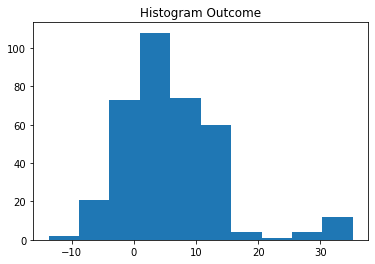

In [3]:
plt.hist(y)
plt.title('Histogram Outcome')
plt.show()

## Gaussian Model

In [4]:
with pm.Model() as model_gaussian:
    # Prior distribution
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    beta0 = pm.Normal("beta0", 0, sigma=20)
    beta1 = pm.Normal("beta1", 0, sigma=20)
    
    # Likelihood
    lik = pm.Normal('y', mu = beta0 + beta1 * x, sigma=sigma, observed=y)
        
    # draw 1000 posterior samples using NUTS sampling + 1000 of warmup on 4 chain
    trace_gaussian = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 195 seconds.


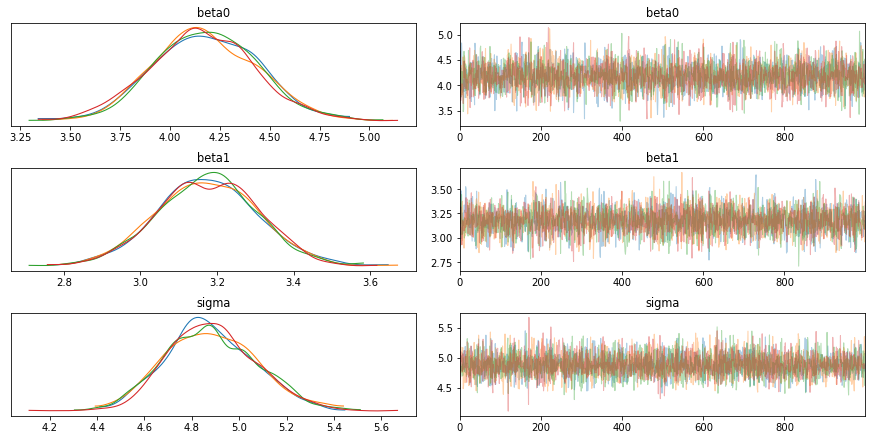

In [5]:
az.plot_trace(trace_gaussian);

## T-Student Model

In [6]:
with pm.Model() as model_tstudent:
    # Prior distribution
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    beta0 = pm.Normal("beta0", 0, sigma=20)
    beta1 = pm.Normal("beta1", 0, sigma=20)
    n = pm.Gamma('n', alpha = 2, beta = 0.1)
    
    # Likelihood
    lik = pm.StudentT('y', nu=n, mu = beta0 + beta1 * x, sigma=sigma, observed=y)
        
    # draw 1000 posterior samples using NUTS sampling + 1000 of warmup on 4 chain
    trace_tstudent = pm.sample(1000, tune=1000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n, beta1, beta0, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 200 seconds.


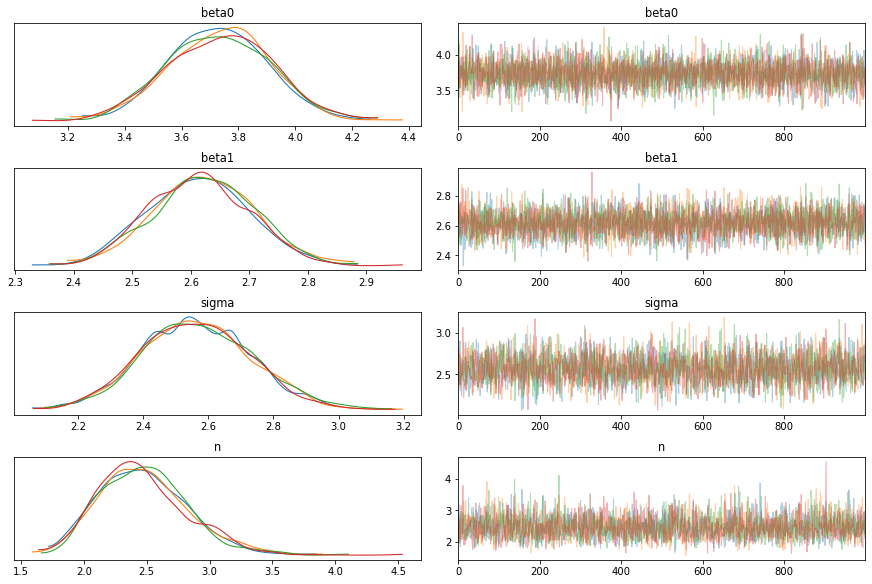

In [7]:
az.plot_trace(trace_tstudent);

## Results

In [8]:
az.summary(trace_gaussian)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0,4.177,0.261,3.676,4.652,0.004,0.003,4913.0,4895.0,4916.0,3063.0,1.0
beta1,3.175,0.131,2.931,3.420,0.002,0.001,4556.0,4556.0,4539.0,2672.0,1.0
sigma,4.882,0.190,4.554,5.257,0.002,0.002,6039.0,5965.0,6081.0,2737.0,1.0


In [9]:
az.summary(trace_tstudent)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0,3.733,0.178,3.400,4.059,0.003,0.002,4778.0,4778.0,4773.0,3187.0,1.0
beta1,2.618,0.086,2.457,2.775,0.001,0.001,4360.0,4357.0,4344.0,3204.0,1.0
sigma,2.565,0.170,2.258,2.893,0.003,0.002,2921.0,2913.0,2930.0,3262.0,1.0
n,2.476,0.350,1.814,3.087,0.007,0.005,2806.0,2806.0,2778.0,3139.0,1.0


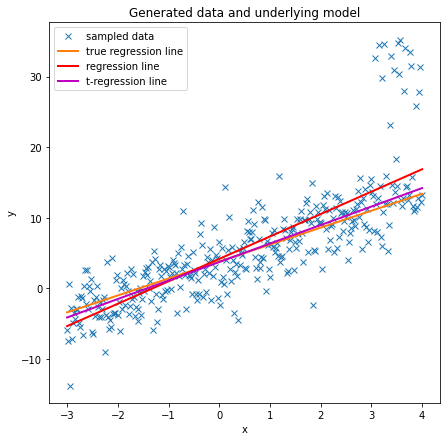

In [10]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, b0 + b1*x, label="true regression line", lw=2.0)
ax.plot(x, trace_gaussian["beta0"].mean() + trace_gaussian["beta1"].mean()*x, label="regression line", lw=2.0, color = "r")
ax.plot(x, trace_tstudent["beta0"].mean() + trace_tstudent["beta1"].mean()*x, label="t-regression line", lw=2.0, color = "m")
plt.legend(loc=0);